In [1]:
%autosave 1

Autosaving every 1 seconds


In [2]:
import scvi
import skmisc
import scanpy as sc
import anndata as ad
import scanpy.external as sce
from anndata import AnnData
import numpy as np
import pandas as pd
import matplotlib as plt
import os
import seaborn as sns

Global seed set to 0
/storage1/fs1/martyomov/Active/IndividualBackUps/romans/.conda/envs/sc_scanpy/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(
Matplotlib created a temporary config/cache directory at /tmp/629275.tmpdir/matplotlib-5j1bc459 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
path = '/storage1/fs1/martyomov/Active/collaborations/greg_brian/greg_wu/romans/'

In [4]:
pal1 = sns.color_palette('colorblind')
pal1

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [47]:
adata = sc.read_10x_mtx(path + f'CLOCK/data/raw_counts/5_BSE_C')
adata

/storage1/fs1/martyomov/Active/IndividualBackUps/romans/.conda/envs/sc_scanpy/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


AnnData object with n_obs × n_vars = 3561 × 45924
    var: 'gene_ids', 'feature_types'

In [69]:
adata_2 = sc.read_10x_h5(path + f'CLOCK/data/whole/1307_001_YR2_P/sample_feature_bc_matrix.h5')
adata_2

/storage1/fs1/martyomov/Active/IndividualBackUps/romans/.conda/envs/sc_scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 851 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

## Doublet removal

In [6]:
sc.pp.filter_genes(adata, min_cells=10)

In [7]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset = True, flavor = 'seurat_v3')

In [8]:
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|█████████████████████████████████████████████████████████████████| 400/400 [03:42<00:00,  1.73it/s, loss=602, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████████████████████████████████████████████████████████████████| 400/400 [03:42<00:00,  1.80it/s, loss=602, v_num=1]


In [9]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


/storage1/fs1/martyomov/Active/IndividualBackUps/romans/.conda/envs/sc_scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 192/400:  48%|██████████████████████████████▋                                 | 192/400 [01:01<01:06,  3.11it/s, loss=0.28, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.250. Signaling Trainer to stop.


In [10]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)
df.index = df.index.map(lambda x:x[:-2])
df

,doublet,singlet,prediction
AAACCTGAGCCACGCT-1,-2.302701,2.998978,singlet
AAACCTGAGCGTTGCC-1,-0.619471,1.179001,singlet
AAACCTGAGCTACCTA-1,-0.640858,1.914956,singlet
AAACCTGGTAGCGTCC-1,-2.223519,3.018978,singlet
AAACCTGGTCTTCAAG-1,0.700905,-0.358311,doublet
...,...,...,...
TTTGTCAAGGTGATAT-1,-0.713632,1.165163,singlet
TTTGTCAAGTGGGTTG-1,-0.188088,0.588371,singlet
TTTGTCACATCACGTA-1,-0.860509,1.500292,singlet
TTTGTCATCCGAATGT-1,-0.589365,0.996410,singlet


In [12]:
df['dif'] = df.doublet - df.singlet
sns.displot(df[df.prediction == 'doublet'], x = 'dif')

In [14]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
doublets

,doublet,singlet,prediction,dif
AAACCTGGTCTTCAAG-1,0.700905,-0.358311,doublet,1.059216
AAAGATGCATTCCTGC-1,0.410662,-0.956461,doublet,1.367123
AAAGATGGTATGAATG-1,2.223366,-1.362160,doublet,3.585526
AAAGATGGTCTAGAGG-1,1.021647,-0.646260,doublet,1.667906
AAAGTAGTCGGATGTT-1,1.927378,-1.729912,doublet,3.657290
...,...,...,...,...
TTGGCAATCAACACTG-1,1.715713,-0.112596,doublet,1.828309
TTTACTGGTGGTACAG-1,1.056241,-0.703693,doublet,1.759935
TTTATGCCAGATGAGC-1,2.213782,-2.060551,doublet,4.274333
TTTGGTTGTATATGGA-1,0.877876,-0.299581,doublet,1.177457


In [48]:
# one way to map doublets on fresh adata
adata.obs['solid_doublets'] = adata.obs_names.isin(doublets.index)
# optional: filter them out
adata = adata[~adata.obs.solid_doublets == True]
adata

View of AnnData object with n_obs × n_vars = 3365 × 45924
    obs: 'solid_doublets'
    var: 'gene_ids', 'feature_types'

In [26]:
# create a colm with doublets which were confidently predicted as doublets
adata.obs['solid_prediction'] = 'singlet'
adata.obs.loc[adata[(adata.obs.prediction.isin(['doublet'])) & (adata.obs['dif'] > 1)].obs_names, 'solid_prediction'] = 'doublet'

In [28]:
adata

AnnData object with n_obs × n_vars = 3561 × 3000
    obs: '_scvi_batch', '_scvi_labels', 'prediction', 'dif', 'solid_prediction'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'

In [29]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)  
sc.tl.umap(adata)

In [30]:
sc.tl.leiden(adata, resolution = 0.5)

/storage1/fs1/martyomov/Active/IndividualBackUps/romans/.conda/envs/sc_scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/storage1/fs1/martyomov/Active/IndividualBackUps/romans/.conda/envs/sc_scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/storage1/fs1/martyomov/Active/IndividualBackUps/romans/.conda/envs/sc_scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


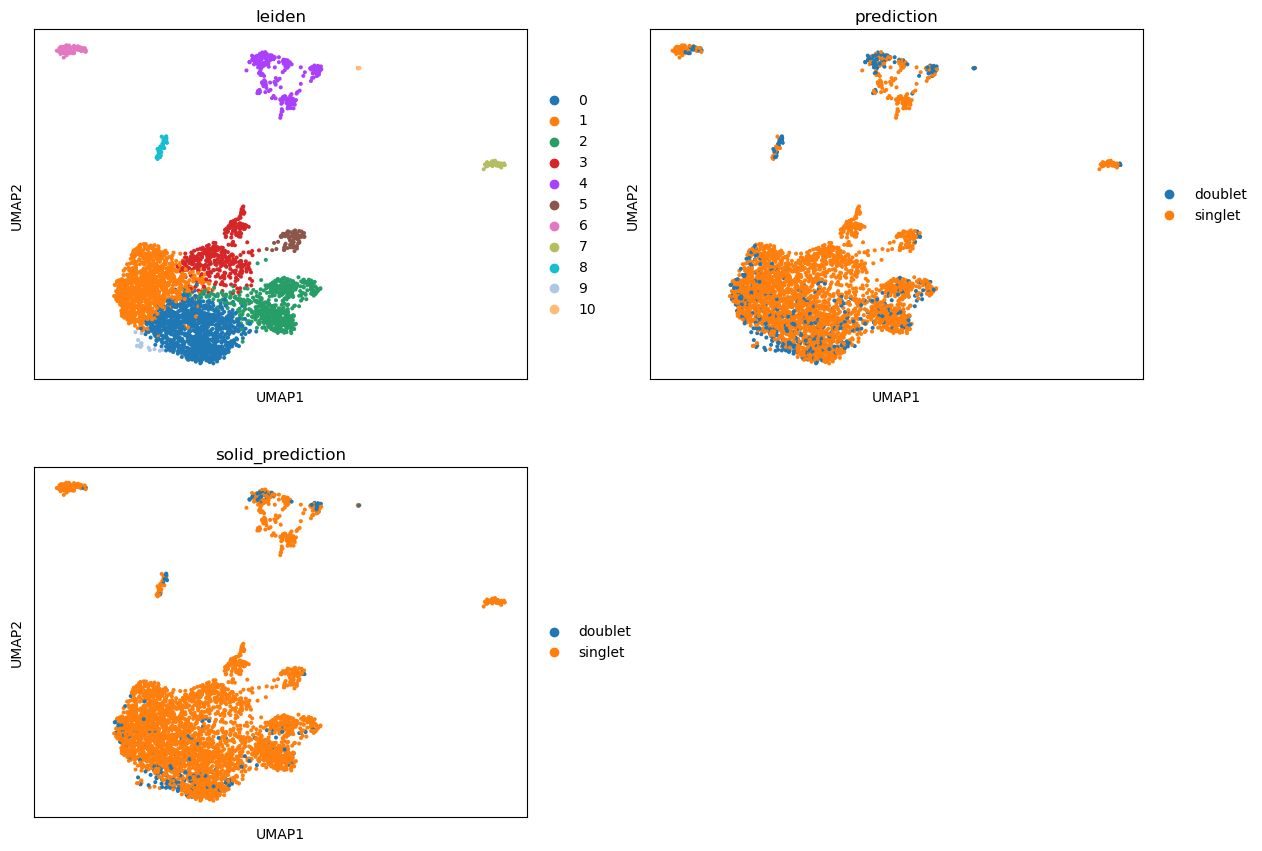

In [46]:
sc.pl.umap(adata, color=['leiden', 'prediction', 'solid_prediction'], ncols=2)